In [1]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib.patches import Ellipse

from abc import ABC, abstractmethod

In [2]:
class Neuron:
    def __init__(self, mean, cov, coord):
        self.mean_ = mean
        self.cov_ = cov
        self.coord_ = coord

In [3]:
class Lattice(ABC):
    def __init__(self, size):
        self.size_ = size
        self.neurons_ = None
        self.neurons_nb_ = None

        self.generate()

    @abstractmethod
    def generate(self):
        pass


class RectangularLattice(Lattice):
    def generate(self):
        self.neurons_ = []
        self.neurons_nb_ = self.size_[0] * self.size_[1]

        for i in range(0, self.size_[0]):
            for j in range(0, self.size_[1]):
                self.neurons_.append(Neuron(None, None, np.array([i, j])))


In [112]:
class SOMM:
    def __init__(self, lattice: Lattice, learning_rate):
        self.learning_rate_ = learning_rate
        self.alpha_ = None
        self.lattice_ = lattice

    def fit(self, X: np.ndarray, epochs):
        neurons_nb = self.lattice_.neurons_nb_
        neurons = self.lattice_.neurons_

        indexes = np.random.choice(X.shape[0], neurons_nb, replace=False)

        for i in range(0, neurons_nb):
            neurons[i].mean_ = X[indexes[i]]
            neurons[i].cov_ = self.initialize_cov(X.shape[1])
            print(neurons[i].cov_)

        for ep in range(epochs):
            self.alpha_ = np.sqrt(ep + 1) * self.learning_rate_
            print("Epoch:", ep)
            print("1/2*sigma^2:", self.alpha_)
            print("Weights, Covariance:")
            for neuron in self.lattice_.neurons_:
                print(neuron.mean_, end=' ')
                #print(neuron.cov_, end=' ')
            print()

            bmus_idx = []
            for x in X:
                # Find best matching unit for x_n
                winner_idx = self.find_bmu(x)
                bmus_idx.append(winner_idx)

            # Update nodes
            self.update_nodes(bmus_idx, X)

    def neighbourhood_func(self, r, s):
        # r - fixed neuron index
        # s - arbitrary neuron index

        numerator = np.exp(-self.alpha_ * self.distance(self.lattice_.neurons_[r].coord_, self.lattice_.neurons_[s].coord_))
        denominator = 0

        for neuron in self.lattice_.neurons_:
            denominator += np.exp(-self.alpha_ * self.distance(self.lattice_.neurons_[r].coord_, neuron.coord_))

        return numerator / denominator

    def find_bmu(self, x):
        # returns winner_idx
        min_d = np.inf
        winner_idx = None

        for i in range(self.lattice_.neurons_nb_):
            d = self.bmu_distance(x, i)
            if d < min_d:
                min_d = d
                winner_idx = i

        return winner_idx

    @staticmethod
    def distance(v1: np.ndarray, v2: np.ndarray):
        # Calculating euclidian distance
        return np.sqrt(np.sum((v1 - v2) ** 2))

    def bmu_distance(self, x, neuron_idx):
        distance = 0
        for i, neuron in enumerate(self.lattice_.neurons_):
            nb_val = self.neighbourhood_func(neuron_idx, i)

            #distance += nb_val * (self.distance(x, self.lattice_.neurons_[i].mean_) / 2 + np.log(nb_val))
            distance += nb_val * ((np.log(np.linalg.det(neuron.cov_)) + (x - neuron.mean_).T @ np.linalg.inv(neuron.cov_) @ (x - neuron.mean_))/2 + np.log(nb_val))

        return distance

    def update_nodes(self, bmus_idx, X):
        # Updating all neuron based on batch mode

        for neuron_idx in range(self.lattice_.neurons_nb_):
            numerator_mean = 0
            numerator_cov = 0
            denominator = 0

            for i, x in enumerate(X):
                nb_val = self.neighbourhood_func(bmus_idx[i], neuron_idx)

                numerator_cov += nb_val * np.outer((x - self.lattice_.neurons_[neuron_idx].mean_), (x - self.lattice_.neurons_[neuron_idx].mean_))
                numerator_mean += nb_val * x
                denominator += nb_val

            self.lattice_.neurons_[neuron_idx].mean_ = numerator_mean / denominator
            self.lattice_.neurons_[neuron_idx].cov_ = (numerator_cov / denominator).reshape(X.shape[1], X.shape[1])
            
    
    @staticmethod
    def initialize_cov(n):
        cov_matrix = np.zeros((n, n))
        
        # Set the diagonal elements to 1
        np.fill_diagonal(cov_matrix, 1.0)
        return cov_matrix

### Example 1

Text(0.5, 1.0, '1D Gaussian Mixture Dataset')

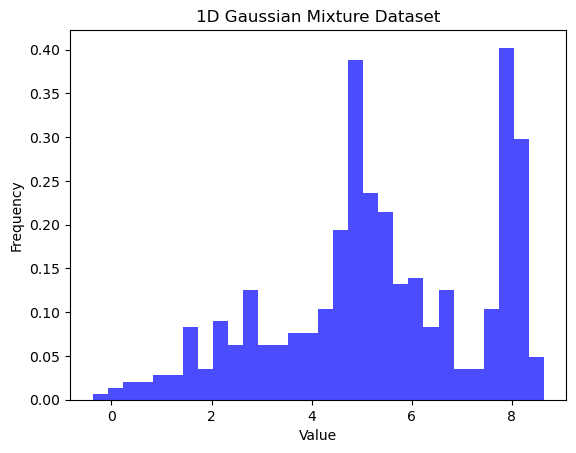

In [23]:
# Define the parameters for the Gaussian mixture
means = np.array([3, 5, 6, 8])
variances = np.array([1.2, 0.4, 0.9, 0.2])
n_samples = 120

# Generate data points from the Gaussian mixture
data = np.concatenate([np.random.normal(means[i], variances[i], n_samples) for i in range(len(means))])

# Visualize the generated data
hist_data, bin_edges, _ = plt.hist(data, bins=30, density=True, alpha=0.7, color='b')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('1D Gaussian Mixture Dataset')

In [24]:
data

array([ 2.75002216,  3.9418619 ,  1.64779574,  2.70484604,  1.72033642,
        3.83963486,  3.20915655,  2.78603549,  3.62397154,  2.67511533,
        0.51479607,  3.47040476,  2.16422573,  4.12506561,  3.37163857,
        1.4541963 ,  4.54015378,  4.85438012,  3.70739335,  2.54691035,
        3.51231676,  3.16795911,  2.62877738,  2.02873395,  5.66121795,
        3.14453445,  3.70099018,  2.13700161, -0.37332268,  0.22164906,
        3.31513211,  3.18376769,  5.57937433,  2.06387583,  2.70399694,
        4.47551928,  1.20348976,  2.46185177,  0.45752032,  2.59433579,
        2.29796799,  1.38760615,  1.01579728,  2.78632706,  2.90742937,
        1.5123704 ,  2.78171118,  3.03537886,  0.8197738 ,  4.65942778,
        2.37575721,  3.64244113,  1.66585312,  2.54713857,  1.9354229 ,
        3.92478142,  2.75978092,  2.11829892,  1.98662536,  3.41450447,
        0.3254156 ,  1.6710866 ,  1.92760992,  3.04030263,  3.90208623,
        0.82172913,  3.30052044,  4.35482771,  1.82793323,  2.73

In [25]:
X = data.reshape(-1, 1)
X

array([[ 2.75002216],
       [ 3.9418619 ],
       [ 1.64779574],
       [ 2.70484604],
       [ 1.72033642],
       [ 3.83963486],
       [ 3.20915655],
       [ 2.78603549],
       [ 3.62397154],
       [ 2.67511533],
       [ 0.51479607],
       [ 3.47040476],
       [ 2.16422573],
       [ 4.12506561],
       [ 3.37163857],
       [ 1.4541963 ],
       [ 4.54015378],
       [ 4.85438012],
       [ 3.70739335],
       [ 2.54691035],
       [ 3.51231676],
       [ 3.16795911],
       [ 2.62877738],
       [ 2.02873395],
       [ 5.66121795],
       [ 3.14453445],
       [ 3.70099018],
       [ 2.13700161],
       [-0.37332268],
       [ 0.22164906],
       [ 3.31513211],
       [ 3.18376769],
       [ 5.57937433],
       [ 2.06387583],
       [ 2.70399694],
       [ 4.47551928],
       [ 1.20348976],
       [ 2.46185177],
       [ 0.45752032],
       [ 2.59433579],
       [ 2.29796799],
       [ 1.38760615],
       [ 1.01579728],
       [ 2.78632706],
       [ 2.90742937],
       [ 1

In [26]:
lattice = RectangularLattice((2, 3))
som = SOMM(lattice, 1.005)

In [27]:
som.fit(X, 100)

[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
Epoch: 0
1/2*sigma^2: 1.005
Weights, Covariance:
[5.38373875] [[1.]] [7.86635493] [[1.]] [4.78398684] [[1.]] [5.38520953] [[1.]] [8.04559138] [[1.]] [3.90208623] [[1.]] 
Epoch: 1
1/2*sigma^2: 1.4212846301849604
Weights, Covariance:
[5.8396482] [[1.9905087]] [6.29974003] [[6.20005827]] [5.04406312] [[4.0826369]] [5.70257825] [[3.16821368]] [5.26802567] [[12.61316169]] [3.90695231] [[4.66958128]] 
Epoch: 2
1/2*sigma^2: 1.7407110616067214
Weights, Covariance:
[5.73104455] [[1.21763395]] [6.46360201] [[3.34949672]] [5.13148679] [[5.66826395]] [5.70355428] [[2.43193663]] [5.23948564] [[5.06077727]] [3.34585464] [[4.25534805]] 
Epoch: 3
1/2*sigma^2: 2.01
Weights, Covariance:
[5.64852074] [[0.97418943]] [6.95516936] [[2.747301]] [5.33809995] [[6.46863166]] [5.55315495] [[2.18259633]] [4.90314052] [[3.31811619]] [3.0572144] [[3.60897541]] 
Epoch: 4
1/2*sigma^2: 2.2472483173872884
Weights, Covariance:
[5.66480667] [[0.81985009]] [7.11925514] [[2.1078127

In [28]:
for neuron in som.lattice_.neurons_:
    print(neuron.mean_, neuron.cov_)

[5.77854948] [[0.05082613]]
[7.98794703] [[0.04363505]]
[6.70053726] [[0.10573161]]
[5.03409661] [[0.04318436]]
[4.14456724] [[0.16087577]]
[2.09508953] [[0.70766572]]


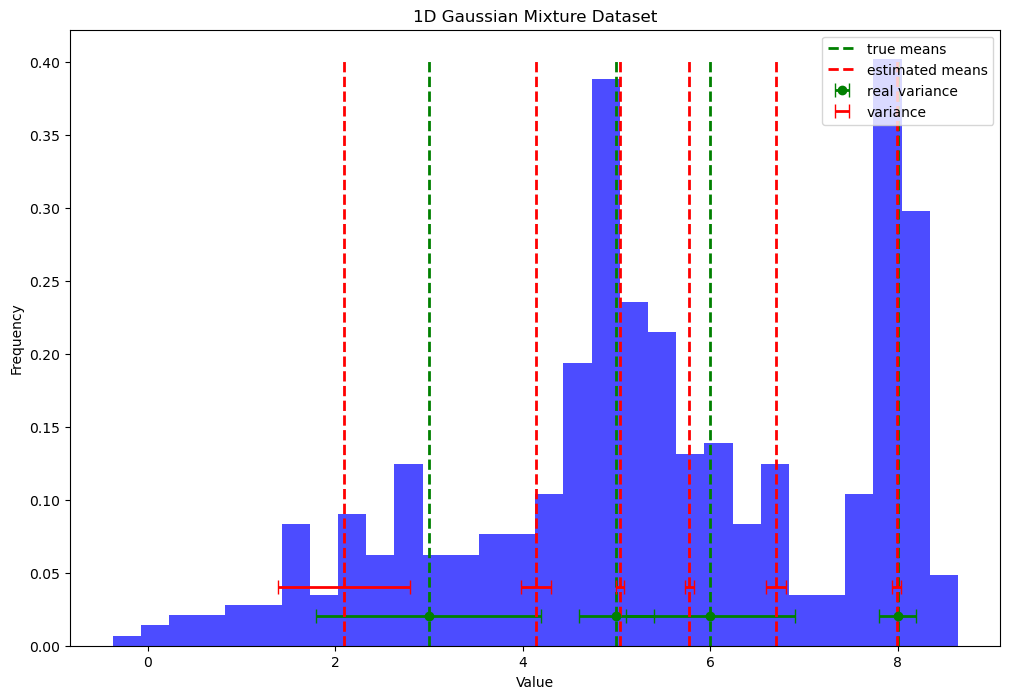

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))

# Visualize the generated data
ax.hist(data, bins=30, density=True, alpha=0.7, color='b')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('1D Gaussian Mixture Dataset')

neuron_variances = np.array([neuron.cov_[0] for neuron in som.lattice_.neurons_]).flatten()
neuron_weights = np.array([neuron.mean_ for neuron in som.lattice_.neurons_]).flatten()

# Plot vertical lines for real means:
ax.vlines(x=means, color='g', linestyle='--', linewidth=2, label='true means', ymin=0, ymax=max(hist_data))
ax.errorbar(means, np.full(len(means), max(hist_data) * 0.05), xerr=variances, fmt='go', elinewidth=2, capsize=5, label='real variance')

# Plot vertical lines for neuron weights
ax.vlines(x=neuron_weights, color='r', linestyle='--', linewidth=2, label='estimated means', ymin=0, ymax=max(hist_data))
ax.errorbar(x=neuron_weights, y=np.full(len(neuron_weights), max(hist_data) * 0.1), xerr=neuron_variances, color='r', fmt='none', elinewidth=2, capsize=5, label='variance')


ax.legend(loc='upper right');

### Example 2

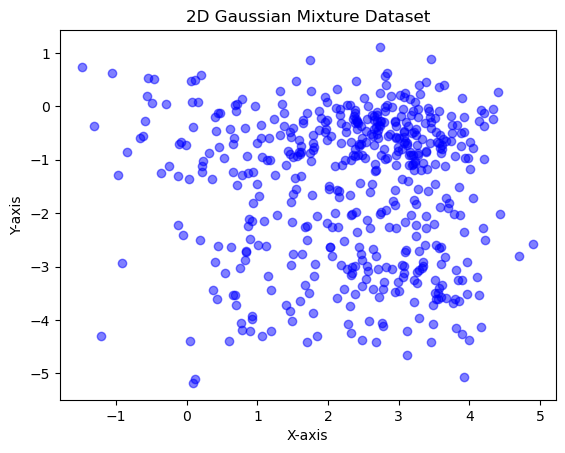

In [7]:
# Define the parameters for the 2D Gaussian mixture
means = np.array([[1, -3], [1, -0.5], [3, -3], [3, -0.5]])
covariances = np.array([[[1, 0], 
                         [0, 0.8]],

                        [[1, 0], 
                         [0, 0.3]],

                        [[0.5, 0], 
                         [0, 0.8]],

                        [[0.5, 0], 
                         [0, 0.3]]])

n_samples = [60, 90, 140, 210]

# Generate data points from the 2D Gaussian mixture
data = np.concatenate([np.random.multivariate_normal(mean, cov, n) for mean, cov, n in zip(means, covariances, n_samples)])
np.random.shuffle(data)

# Visualize the generated data
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, color='b')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('2D Gaussian Mixture Dataset')

plt.show()

In [8]:
data

array([[ 3.65978991e+00, -1.12218419e+00],
       [ 1.50534185e+00, -2.76853937e+00],
       [ 2.27343565e+00,  2.55972785e-02],
       [ 1.83652036e+00, -4.30212238e+00],
       [ 8.83662538e-01, -2.11544201e+00],
       [ 3.79398160e+00, -3.60512794e+00],
       [ 3.56532509e+00, -3.39724624e+00],
       [ 2.96041983e+00, -3.75884331e-01],
       [ 2.73232146e+00,  1.11019916e+00],
       [ 1.55396661e+00, -9.35819199e-01],
       [ 3.04025818e+00, -2.96418823e+00],
       [ 3.08002049e+00, -3.12350667e+00],
       [ 3.06773138e+00, -2.98738913e+00],
       [ 3.23331680e+00,  7.68862743e-02],
       [ 2.80603036e+00,  5.56770971e-01],
       [ 3.74183483e+00, -6.52810543e-01],
       [ 2.40378983e+00, -2.71231036e-01],
       [ 3.27046790e+00, -4.82850349e-02],
       [ 2.96401224e+00, -1.10787581e+00],
       [ 3.25260752e+00, -7.33010308e-01],
       [ 3.13519904e+00, -3.73073075e-01],
       [ 2.37512327e+00, -8.04188001e-01],
       [ 6.62462359e-01, -6.02118596e-01],
       [ 3.

In [9]:
lattice = RectangularLattice((2, 2))
som = SOMM(lattice, 1.005)

In [10]:
som.fit(data, 200)

[[1.         0.45172085]
 [0.45172085 1.        ]]
[[1.         0.48795728]
 [0.48795728 1.        ]]
[[1.         0.27847666]
 [0.27847666 1.        ]]
[[1.         0.85111855]
 [0.85111855 1.        ]]
Epoch: 0
1/2*sigma^2: 1.005
Weights, Covariance:
[ 2.3130229 -1.6520782] [ 2.1967231  -1.10093478] [ 2.85063389 -0.55835992] [ 3.60733239 -3.33621965] 
Epoch: 1
1/2*sigma^2: 1.4212846301849604
Weights, Covariance:
[ 2.19128675 -1.23741167] [ 2.32864427 -1.49337251] [ 2.33576729 -1.4942785 ] [ 2.66573168 -2.12296968] 
Epoch: 2
1/2*sigma^2: 1.7407110616067214
Weights, Covariance:
[ 2.25179704 -0.91815535] [ 2.475998   -1.57322178] [ 2.10567938 -1.83741024] [ 2.56187845 -2.29030861] 
Epoch: 3
1/2*sigma^2: 2.01
Weights, Covariance:
[ 2.37282788 -0.73634541] [ 2.5997681  -1.55176721] [ 1.78901753 -2.10734658] [ 2.48262415 -2.43537703] 
Epoch: 4
1/2*sigma^2: 2.2472483173872884
Weights, Covariance:
[ 2.47018131 -0.64857979] [ 2.71166646 -1.56532893] [ 1.57852417 -2.18177291] [ 2.39523691 -2.4

In [12]:
for neuron in som.lattice_.neurons_:
    print(neuron.mean_)
    print(neuron.cov_)
    print()

[ 2.96972936 -0.41903773]
[[ 0.36458672 -0.04527271]
 [-0.04527271  0.20515775]]

[ 3.27804521 -2.88115741]
[[ 0.29261113 -0.03693542]
 [-0.03693542  0.68235431]]

[ 1.27271528 -3.18408106]
[[0.62711539 0.10626693]
 [0.10626693 0.59997055]]

[ 0.83668763 -0.71463956]
[[ 0.77757847 -0.25330166]
 [-0.25330166  0.3830204 ]]



In [13]:
neuron_variances = np.array([neuron.cov_ for neuron in som.lattice_.neurons_])
neuron_weights = np.array([neuron.mean_ for neuron in som.lattice_.neurons_])

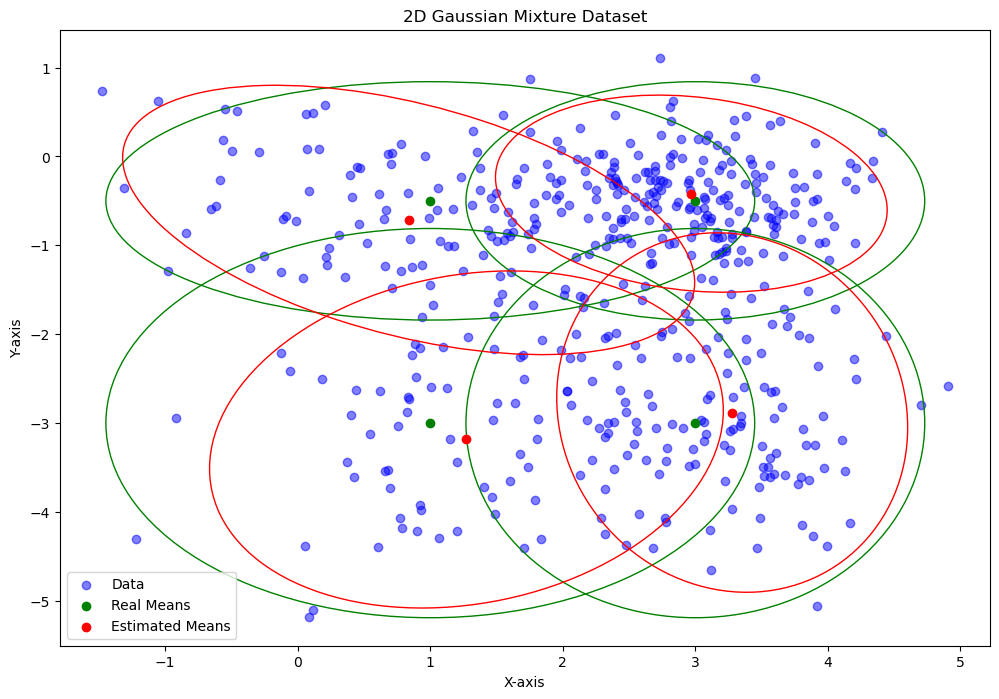

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(data[:, 0], data[:, 1], alpha=0.5, color='b', label='Data')

# Plot means as green points
ax.scatter(means[:, 0], means[:, 1], color='g', marker='o', label='Real Means')

# Plot true parameters
for mean, cov in zip(means, covariances):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * np.sqrt(5.991 * eigenvalues)  # 95% confidence interval
    ell = Ellipse(xy=mean, width=width, height=height, angle=angle, color='g', fill=False)
    ax.add_patch(ell)

# Plot means as red points
ax.scatter(neuron_weights[:, 0], neuron_weights[:, 1], color='r', marker='o', label='Estimated Means')

# Plot neuron parameters
for mean, cov in zip(neuron_weights, neuron_variances):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * np.sqrt(5.991 * eigenvalues)  # 95% confidence interval
    ell = Ellipse(xy=mean, width=width, height=height, angle=angle, color='r', fill=False)
    ax.add_patch(ell)

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('2D Gaussian Mixture Dataset')
ax.legend(loc='best');

### Example 3

In [339]:
def generate_mixture(means, variances, weights, n_samples):
    mixture_idx = np.random.choice(len(weights), size=n_samples, replace=True, p=weights)

    # y is the mixture sample
    data = np.concatenate([np.random.normal(means[i], variances[i]**0.5, size=1) for i in mixture_idx])
    return data, mixture_idx

def generate_independent_data(param1, param2):
    data1, labels1 = generate_mixture(param1[0], param1[1], param1[2], param1[3])
    data2, labels2 = generate_mixture(param2[0], param2[1], param2[2], param2[3])

    data = np.hstack((data1.reshape(-1, 1), data2.reshape(-1, 1)))
    labels = labels1 * len(np.unique(labels2)) + labels2

    return data, labels

In [340]:
n_samples = 500

# Define the parameters for the 2D Gaussian mixture
means1 = np.array([1, 3])
variances1 = np.array([1, 0.5])
weights1 = np.array([0.3, 0.7])
param1 = [means1, variances1, weights1, n_samples]

means2 = np.array([-3, -0.5])
variances2 = np.array([0.8, 0.3])
weights2 = np.array([0.7, 0.3])
param2 = [means2, variances2, weights2, n_samples]

In [341]:
data, labels = generate_independent_data(param1, param2)

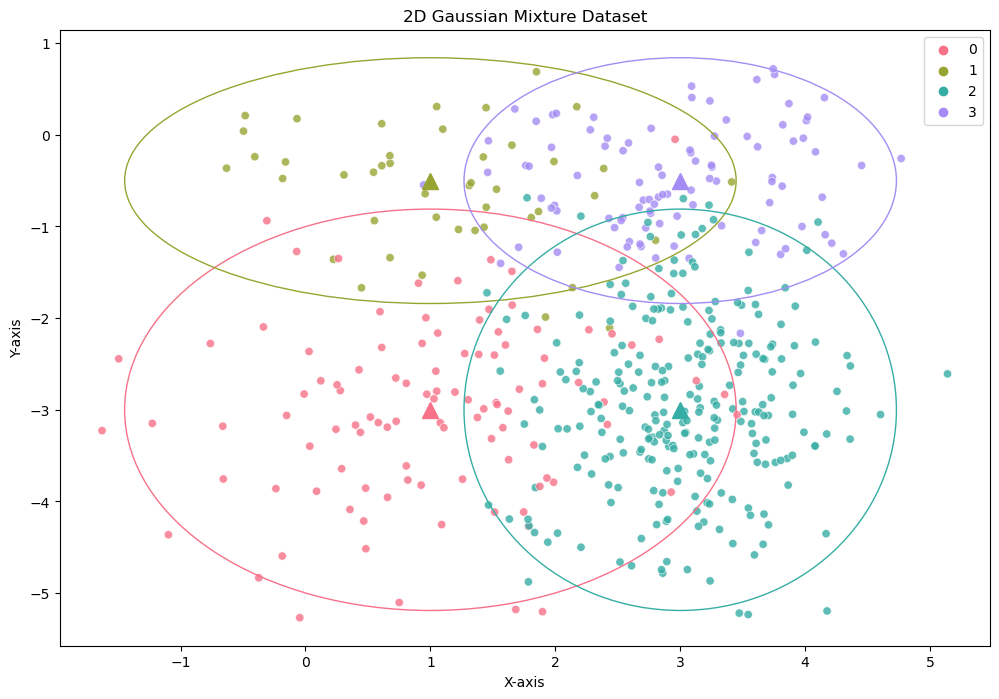

In [361]:
fig, ax = plt.subplots(figsize=(12, 8))

# Generate data points from the 2D Gaussian mixture

custom_palette = sns.color_palette("husl", len(np.unique(labels)))  # Use Seaborn's "husl" palette for n colors

# Visualize the generated data
sns.scatterplot(x=data[:, 0], y=data[:, 1], alpha=0.8, hue=labels, ax=ax, palette=custom_palette)

means = np.array([(x, y) for x in means1 for y in means2])
covariances = np.array([[[1, 0], [0, 0.8]], [[1, 0], [0, 0.3]], [[0.5, 0], [0, 0.8]], [[0.5, 0], [0, 0.3]]])

# Plot true parameters
for mean, cov, color in zip(means, covariances, custom_palette):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * np.sqrt(5.991 * eigenvalues)  # 95% confidence interval
    ell = Ellipse(xy=mean, width=width, height=height, angle=angle, color=color, fill=False)
    ax.add_patch(ell)
    ax.plot(mean[0], mean[1], color=color, markersize=12, marker='^')


ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('2D Gaussian Mixture Dataset');

In [343]:
lattice = RectangularLattice((2, 2))
som = SOMM(lattice, 1.003)

In [344]:
som.fit(data, 200)

[[1. 0.]
 [0. 1.]]
[[1. 0.]
 [0. 1.]]
[[1. 0.]
 [0. 1.]]
[[1. 0.]
 [0. 1.]]
Epoch: 0
1/2*sigma^2: 1.003
Weights, Covariance:
[ 1.89705141 -2.71576826] [-0.0106071  -2.82792142] [ 3.84059649 -1.66895411] [ 2.89441815 -3.15942675] 
Epoch: 1
1/2*sigma^2: 1.4184562030602144
Weights, Covariance:
[ 2.21689496 -2.15613908] [ 1.83672497 -2.44426881] [ 2.84221885 -1.90287428] [ 2.63451645 -2.72851443] 
Epoch: 2
1/2*sigma^2: 1.7372469599915836
Weights, Covariance:
[ 2.00853748 -1.7954848 ] [ 1.67716623 -2.50579953] [ 2.93171748 -1.74414687] [ 2.77613838 -2.98017123] 
Epoch: 3
1/2*sigma^2: 2.006
Weights, Covariance:
[ 1.93749427 -1.49659522] [ 1.44671814 -2.6841146 ] [ 2.97433086 -1.56641123] [ 2.82616115 -3.05495626] 
Epoch: 4
1/2*sigma^2: 2.242776181432289
Weights, Covariance:
[ 1.80850114 -1.29247241] [ 1.35487792 -2.84582306] [ 3.01037274 -1.45826085] [ 2.88552195 -3.10037458] 
Epoch: 5
1/2*sigma^2: 2.4568382120115273
Weights, Covariance:
[ 1.64768225 -1.16797049] [ 1.34288145 -3.01812028] [ 

In [345]:
neuron_means = np.array([neuron.mean_ for neuron in som.lattice_.neurons_])
neuron_variances = np.array([neuron.cov_ for neuron in som.lattice_.neurons_])

In [346]:
neuron_means

array([[ 1.28347782, -0.52802572],
       [ 1.12649199, -3.20707999],
       [ 3.1535797 , -0.99036755],
       [ 3.22491367, -3.24204968]])

In [347]:
means

array([[ 1. , -3. ],
       [ 1. , -0.5],
       [ 3. , -3. ],
       [ 3. , -0.5]])

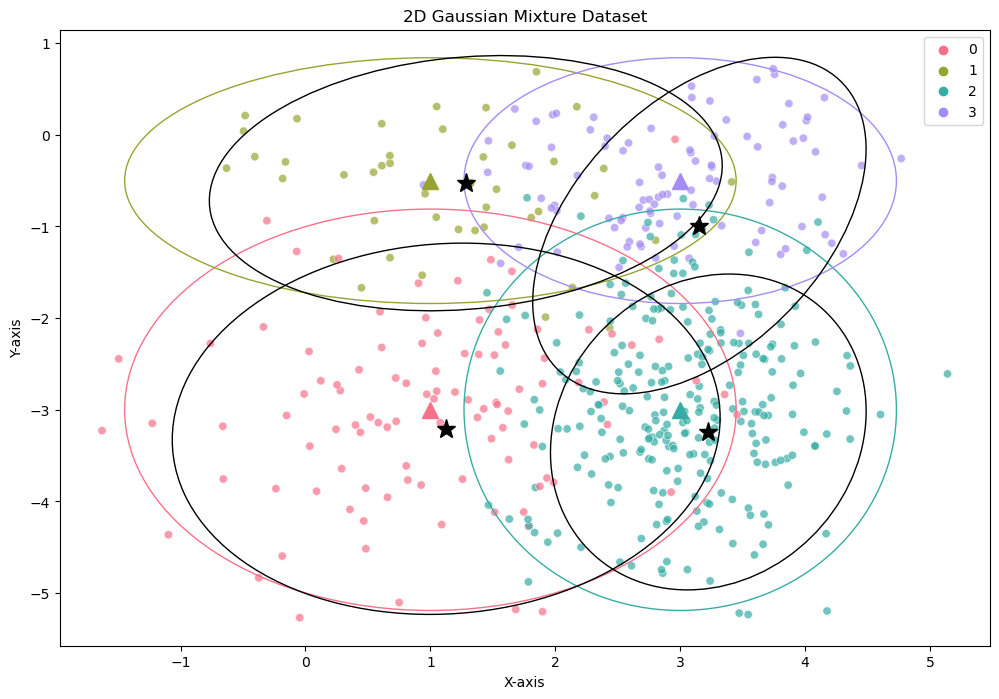

In [348]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.scatterplot(x=data[:, 0], y=data[:, 1], alpha=0.7, hue=labels, ax=ax, palette=custom_palette)


# Plot true parameters
for mean, cov, color in zip(means, covariances, custom_palette):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * np.sqrt(5.991 * eigenvalues)  # 95% confidence interval
    ell = Ellipse(xy=mean, width=width, height=height, angle=angle, color=color, fill=False)
    ax.add_patch(ell)
    ax.plot(mean[0], mean[1], color=color, markersize=12, marker='^')


# Plot neuron parameters
for mean, cov in zip(neuron_means, neuron_variances):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * np.sqrt(5.991 * eigenvalues)  # 95% confidence interval
    ell = Ellipse(xy=mean, width=width, height=height, angle=angle, color='black', fill=False)
    ax.add_patch(ell)
    ax.plot(mean[0], mean[1], color='black', markersize=14, marker='*')

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('2D Gaussian Mixture Dataset')
ax.legend(loc='best');

### Example 4

In [363]:
def covariance(prob_matrix):
    # TODO ??????
    x_vals = np.arange(prob_matrix.shape[1])
    y_vals = np.arange(prob_matrix.shape[0])

    mean_x = np.sum(prob_matrix * x_vals)
    mean_y = np.sum(prob_matrix * y_vals)
    var_x = np.sum(prob_matrix * (np.arange(prob_matrix.shape[1]) - mean_x) ** 2)
    var_y = np.sum(prob_matrix * (np.arange(prob_matrix.shape[0]) - mean_y) ** 2)


    # Calculate the covariance matrix
    cov_matrix = np.zeros((2, 2))
    for i in range(prob_matrix.shape[0]):
        for j in range(prob_matrix.shape[1]):
            cov_matrix[0, 1] += (i - mean_x) * (j - mean_y) * prob_matrix[i, j]


    cov_matrix[1, 0] = cov_matrix[0, 1]

    cov_matrix[0, 0] = var_x
    cov_matrix[1, 1] = var_y

    return cov_matrix

In [364]:
def generate_dependent_mixture(means1, variances1, means2, variances2, probabilities_matrix, n_samples):
    probabilities = probabilities_matrix.flatten()
    sample_index = np.random.choice(a=probabilities.size, p=probabilities, size=n_samples)
    adjusted_index = np.unravel_index(sample_index, probabilities_matrix.shape)
    mixture_indexes = np.vstack(adjusted_index)
    
    labels = []
    data = []
    for label, idx in zip(sample_index, mixture_indexes.T):
        mix1_idx = idx[0]
        mix2_idx = idx[1]

        mix1_val = np.random.normal(means1[mix1_idx], variances1[mix1_idx]**0.5)
        mix2_val = np.random.normal(means2[mix2_idx], variances2[mix2_idx]**0.5)
        
        data.append([mix1_val, mix2_val])
        labels.append(label)

    return np.array(data), np.array(labels)

In [365]:
n_samples = 1500

# Define the parameters for the 2D Gaussian mixture
means1 = np.array([1, 5])
variances1 = np.array([1, 0.5])

means2 = np.array([-3, -0.5])
variances2 = np.array([0.8, 0.3])

probabilities = np.array([[0.3, 0.1],
                          [0.1, 0.5]])

In [366]:
data, labels = generate_dependent_mixture(means1, variances1, means2, variances2, probabilities, 500)

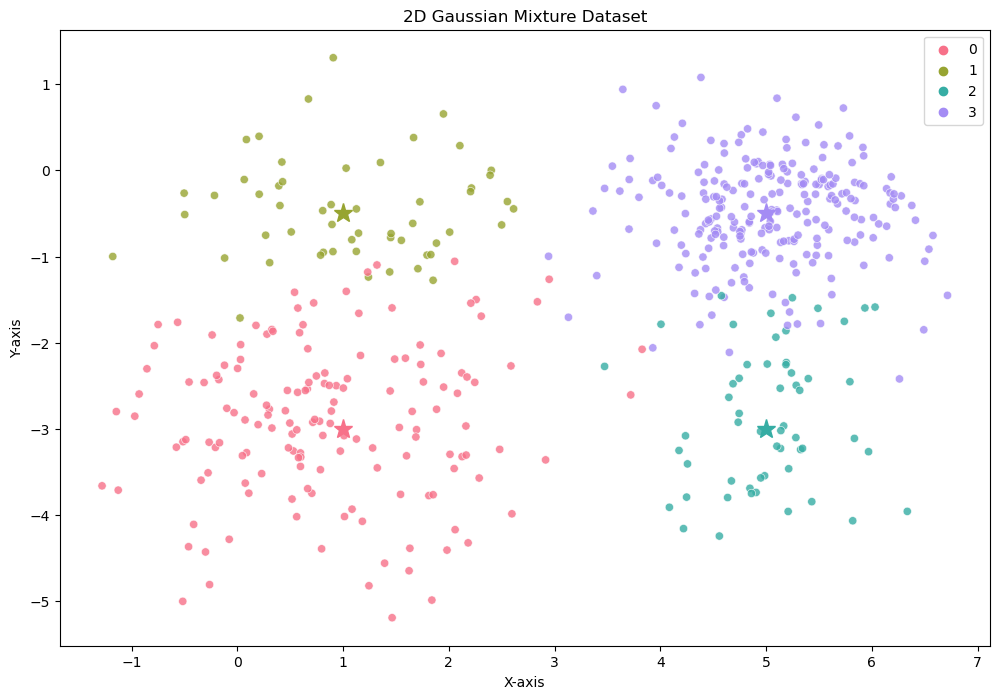

In [367]:
fig, ax = plt.subplots(figsize=(12, 8))

# Generate data points from the 2D Gaussian mixture

custom_palette = sns.color_palette("husl", len(np.unique(labels)))  # Use Seaborn's "husl" palette for n colors

# Visualize the generated data
sns.scatterplot(x=data[:, 0], y=data[:, 1], alpha=0.8, hue=labels, ax=ax, palette=custom_palette)

covariances = np.array([(x, y) for x in variances1 for y in means2])
means = np.array([(x, y) for x in means1 for y in means2])
for mean, color in zip(means, custom_palette):
    ax.plot(mean[0], mean[1], color=color, markersize=14, marker='*')


ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('2D Gaussian Mixture Dataset');

In [368]:
lattice = RectangularLattice((2, 2))
som = SOMM(lattice, 1.002)

In [369]:
som.fit(data, 200)

[[1. 0.]
 [0. 1.]]
[[1. 0.]
 [0. 1.]]
[[1. 0.]
 [0. 1.]]
[[1. 0.]
 [0. 1.]]
Epoch: 0
1/2*sigma^2: 1.002
Weights, Covariance:
[ 5.58976507 -0.99007704] [5.37389433 0.32213776] [-0.20795163 -3.21418046] [ 5.01025827 -2.24726692] 
Epoch: 1
1/2*sigma^2: 1.4170419894978414
Weights, Covariance:
[ 3.27584631 -1.43180963] [ 4.32573497 -0.91757579] [ 2.01357801 -2.01146592] [ 3.54102823 -1.71755024] 
Epoch: 2
1/2*sigma^2: 1.735514909184015
Weights, Covariance:
[ 3.28580746 -1.44145036] [ 4.5233287  -0.79199391] [ 1.66886458 -2.31222923] [ 3.3928005  -1.65146458] 
Epoch: 3
1/2*sigma^2: 2.004
Weights, Covariance:
[ 3.28801149 -1.45673232] [ 4.72250624 -0.71611565] [ 1.43118405 -2.40031477] [ 3.41549269 -1.65976539] 
Epoch: 4
1/2*sigma^2: 2.2405401134547893
Weights, Covariance:
[ 3.28529338 -1.45242264] [ 4.8245436  -0.65899333] [ 1.27183701 -2.45904329] [ 3.45624363 -1.69943751] 
Epoch: 5
1/2*sigma^2: 2.454388722268744
Weights, Covariance:
[ 3.28065002 -1.4572695 ] [ 4.88771451 -0.62038709] [ 1.1

In [370]:
neuron_means = np.array([neuron.mean_ for neuron in som.lattice_.neurons_])
neuron_variances = np.array([neuron.cov_ for neuron in som.lattice_.neurons_])

In [371]:
neuron_means

array([[ 1.54195541, -0.57932356],
       [ 5.11315562, -0.36626156],
       [ 0.73303912, -3.05385626],
       [ 5.00108126, -2.4584543 ]])

In [372]:
means

array([[ 1. , -3. ],
       [ 1. , -0.5],
       [ 5. , -3. ],
       [ 5. , -0.5]])

In [373]:
data.shape

(500, 2)

<Axes: >

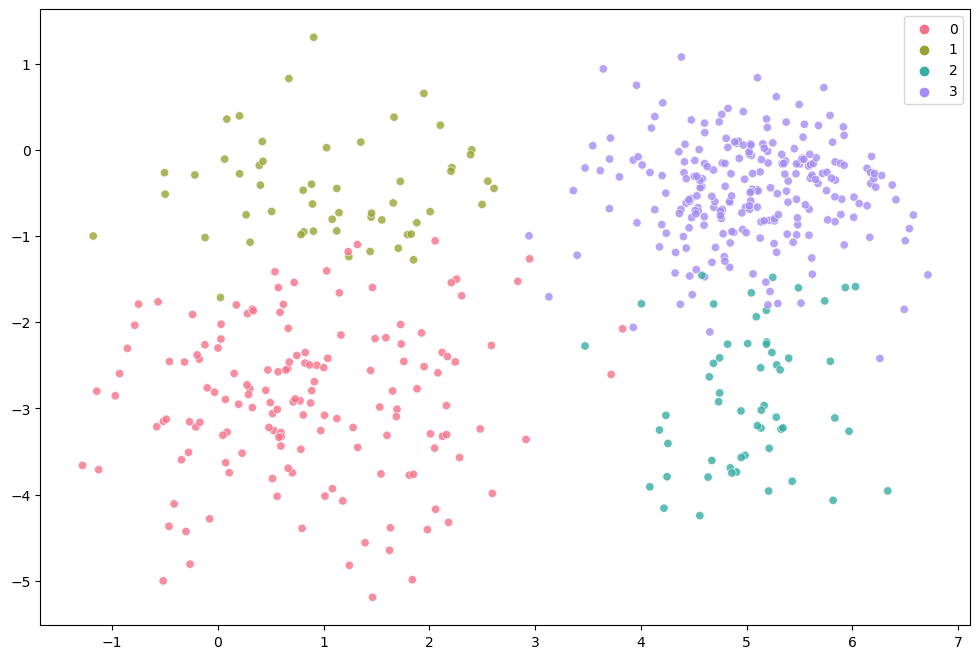

In [374]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.scatterplot(x=data[:, 0], y=data[:, 1], alpha=0.8, hue=labels, ax=ax, palette=custom_palette)

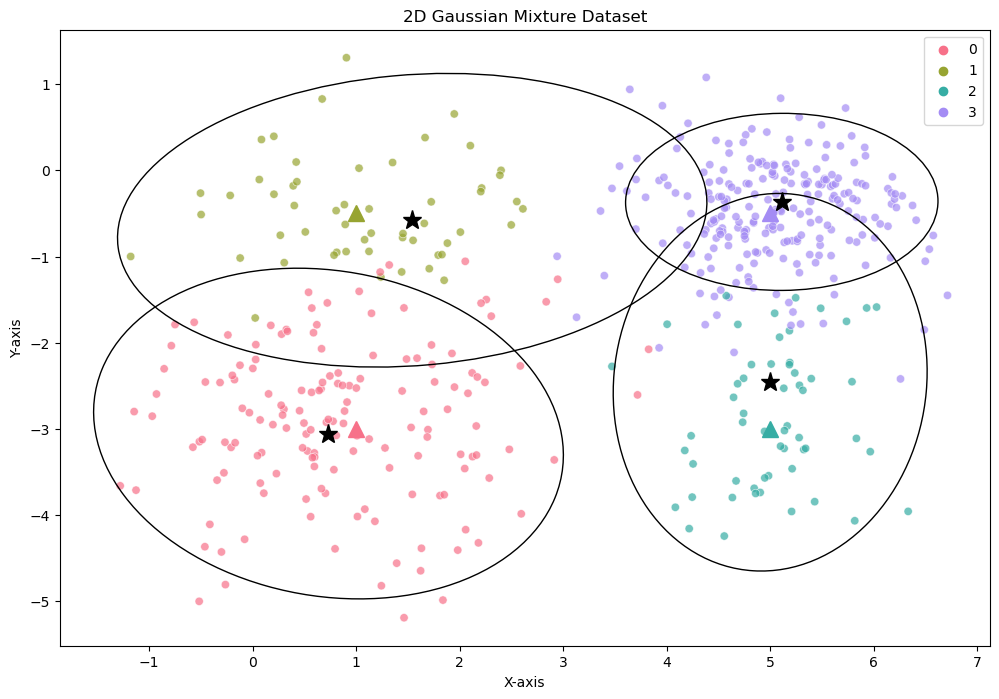

In [375]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.scatterplot(x=data[:, 0], y=data[:, 1], alpha=0.7, hue=labels, ax=ax, palette=custom_palette)


# Plot true parameters
for mean, color in zip(means, custom_palette):
    ax.plot(mean[0], mean[1], color=color, markersize=12, marker='^')


# Plot neuron parameters
for mean, cov in zip(neuron_means, neuron_variances):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * np.sqrt(5.991 * eigenvalues)  # 95% confidence interval
    ell = Ellipse(xy=mean, width=width, height=height, angle=angle, color='black', fill=False)
    ax.add_patch(ell)
    ax.plot(mean[0], mean[1], color='black', markersize=14, marker='*')

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('2D Gaussian Mixture Dataset')
ax.legend(loc='best');